# Abstract: Brain Tumor Classification Using MRI Imaging and Machine Learning

Brain tumors are abnormal growths of cells within the brain or central nervous system that can be life-threatening, requiring timely and accurate diagnosis. Magnetic Resonance Imaging (MRI) is widely used in detecting and diagnosing brain tumors due to its high-resolution imaging capabilities. However, the complexity of brain tumor types, including gliomas, meningiomas, and pituitary adenomas, combined with variations in image quality, poses a significant challenge in medical imaging.

This study explores the use of machine learning techniques, particularly deep learning models like convolutional neural networks (CNNs), to enhance the accuracy of brain tumor classification based on MRI scans. Leveraging transfer learning with pre-trained models such as ResNet50V2, we aim to develop a robust classifier capable of distinguishing between normal and tumor-affected brain tissues. Additionally, the study focuses on improving model performance in real-world healthcare settings, especially where imaging quality may be suboptimal. Through data augmentation and training on degraded images, the model's robustness to low-quality scans is enhanced, enabling better generalization in diverse clinical environments.

Key performance metrics such as accuracy, precision, recall, and confusion matrix are employed to evaluate the model's effectiveness. The resulting classifier aims to support radiologists and healthcare professionals by providing a reliable, automated tool for early brain tumor detection, leading to improved patient outcomes.


![Sample Image](tumor.png)

# Enhanced MRI Brain Tumor Classification :
In this project, we focus on creating a machine learning model that reliably identifies normal(no_tumor) and various tumor-affected brain images, such as pituitary, meningioma, and glioma tumors. Understanding the necessity for accurate diagnoses in regions with limited medical imaging quality, our objective extends to ensuring the model's high performance on low-quality images, thus promoting excellent generalization and utility in diverse healthcare settings.

# Objectives:

1. **Dataset Exploration:** Examine class balances and image dimensions to understand dataset characteristics.
2. **Data Augmentation through Geometric Transformation:** Balance the dataset by applying geometric transformations.
3. **Training on Degraded Image Quality:** Enhance model robustness to low-quality images with controlled degradation techniques.
4. **Transfer Learning for Accuracy:** Use ResNet50V2 pre-trained model for high accuracy without overfitting, despite a limited dataset.
5. **Focused Model Training and Fine-Tuning:** Strategically train and fine-tune the model for reliable MRI image classification.
6. **Performance Evaluation:** Evaluate the model's performance based on accuracy, precision, recall, and confusion matrix.
7. **Model Deployment:** Prepare the model for real-world application by saving and archiving it for deployment.

<a id="contents_tabel"></a>   

<div style="background-color:#e9eef2; padding: 20px; border-radius: 15px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1);">
    <h1 style="font-size:24px; font-family:calibri; color:#102C42;"><b>📋 Table of Contents</b></h1>
    <ul style="font-size:20px; font-family:calibri; line-height: 1.5em;">
        <li><a href="#Initialization" style="text-decoration: none;">Step 1 | Setup and Initialization</a></li>
        <li><a href="#Analysis" style="text-decoration: none;">Step 2 | Dataset Analysis</a></li>
        <li><a href="#Preparation" style="text-decoration: none;">Step 3 | Dataset Preparation</a>
            <ul>
                <li><a href="#Centralizing" style="text-decoration: none;">Step 3.1 | centralize the dataset's information into a DataFrame.</a></li>
                <li><a href="#Centralizing" style="text-decoration: none;">Step 3.2 | Balance the dataset by applying geometric transformations.</a></li>
                <li><a href="#Split" style="text-decoration: none;">Step 3.3 | Data Splitting into Training & Validation Sets.</a></li>
                <li><a href="#Augmentation" style="text-decoration: none;">Step 3.4 | Augmentation of Dataset with Artificially Degraded Images</a></li>
                <!-- <li><a href="#Preprocessing" style="text-decoration: none;">Step 3.5 | Establishing Data Generators for Model Input</a></li> -->
            </ul>
        </li>
        <li><a href="#Model" style="text-decoration: none;">Step 4 | Model Architecture Development</a></li>
        <li><a href="#Train" style="text-decoration: none;">Step 5 | Full Model Training and Fine-Tuning</a></li>
        <li><a href="#Performance" style="text-decoration: none;">Step 6 | Model Performance Assessment</a>
            <ul>
                <li><a href="#Curves" style="text-decoration: none;">Step 6.1 | Visualizing the Learning Curves</a></li>
                <li><a href="#Metrics" style="text-decoration: none;">Step 6.2 | Performance Metrics Assessment</a></li>
            </ul>
        </li>
        <li><a href="#Save" style="text-decoration: none;">Step 7 | Saving the Model for Deployment</a></li>
    </ul>
</div>


# Step-1 | Setup and Initialization

In [3]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import cv2
import random
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model

# Step 2 | Dataset Analysis

In [4]:
# Directory where the image folders are located
base_dir = 'data'
# Obtain class names from the folder names in base_dir
classes = [folder_name for folder_name in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder_name))]
classes

['meningioma_tumor', 'no_tumor', 'pituitary_tumor', 'glioma_tumor']

In [5]:
# function for counting images of each class and their barplot:
def counting_images(base_dir):
    counts = []                  # Counting the number of images in each folder
    for class_name in classes:
        folder_path = os.path.join(base_dir, class_name)
        counts.append(len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]))

    total_count = sum(counts)         
    print('Total number of images including all classes: ',total_count)                                 # Calculating the total number of images
    percentages = [(count / total_count) * 100 for count in counts]    # Calculating the percentages
    plt.figure(figsize=(15, 4))                                        # Set the figure size
    ax = sns.barplot(y=classes, x=counts, orient='h', color='#102C42') # Create a horizontal bar plot
    ax.set_xticks(range(0, max(counts) + 1, 1000))                     # Set x-axis interval (adjust as needed)

    for i, p in enumerate(ax.patches):  # Annotate each bar with the count and percentage
        width = p.get_width()
        ax.text(width + 5, p.get_y() + p.get_height()/2.,
                '{:1.2f}% ({})'.format(percentages[i], counts[i]), 
                va="center", fontsize=15)

    plt.xlabel('Number of Images', fontsize=14)          # Set the x-label for the plot
    ax.set_xticks(range(0, max(counts) + 300, 100))      # Set the x-label for the plot
    plt.title("Number of images per class", fontsize=18) # Set the title and show the plot
    plt.show()

Distribution of data:
Total number of images including all classes:  3265


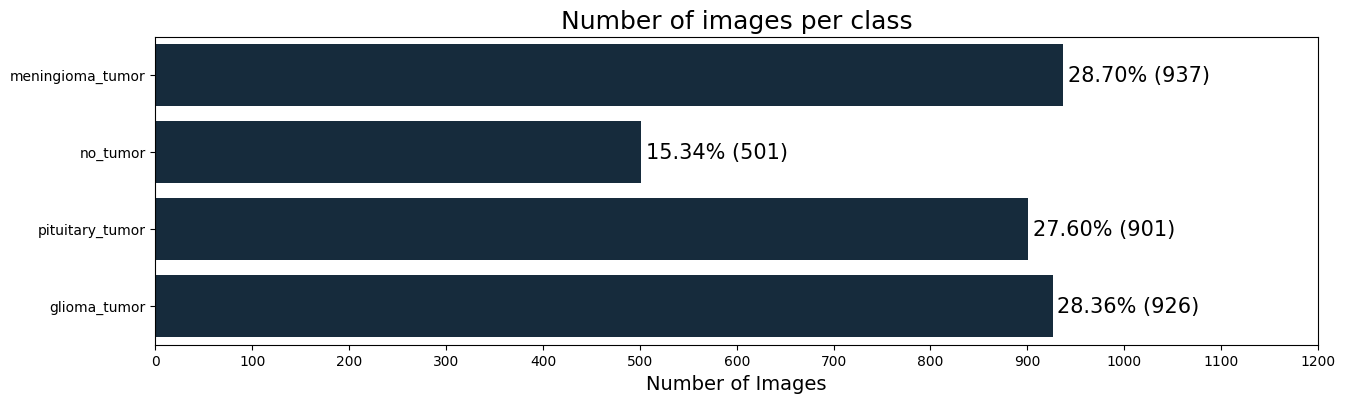

In [6]:
print('Distribution of data:')
counting_images(base_dir)

### Analyzing the dimensions of the images:

In [7]:
# Function for cheaking height and dimensions of each images:
def image_dimensions(base_dir):
    heights = []         # Lists to store heights of all images
    widths = []          # Lists to store widths of all images
    unique_dims = set()  # Initialize sets to store unique dimensions

    # Loop over each class and their respective images
    for class_name in classes:
        folder_path = os.path.join(base_dir, class_name)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                unique_dims.add((img.shape[0], img.shape[1]))    # Add the dimensions (height, width, channels) to the set
                
                # Append heights and widths for statistical calculations
                heights.append(img.shape[0])
                widths.append(img.shape[1])

    if len(unique_dims) == 1:  # Check if all images have the same dimension
        print(f"All images have the same dimensions: {list(unique_dims)[0]}")
    else:
        print(f"There are {len(unique_dims)} different image dimensions in the dataset.")
        print(f"Min height: {min(heights)}, Max height: {max(heights)}, Mean height: {np.mean(heights):.2f}")
        print(f"Min width: {min(widths)}, Max width: {max(widths)}, Mean width: {np.mean(widths):.2f}")

In [8]:
print('Dimensions of data:')
image_dimensions(base_dir)

Dimensions of data:
There are 440 different image dimensions in the dataset.
Min height: 167, Max height: 1446, Mean height: 469.74
Min width: 174, Max width: 1375, Mean width: 467.07


### Resizing all the images into same dimensions:

In [9]:
# Function to resize while maintaining aspect ratio and padding to 256x256
def resize_images(img, target_size=(256, 256)):
    # Get original dimensions
    h, w = img.shape[:2]
    
    # Calculate the scaling factor to maintain aspect ratio
    scale = min(target_size[0] / h, target_size[1] / w)
    
    # Calculate the new dimensions
    new_h, new_w = int(h * scale), int(w * scale)
    
    # Resize the image while maintaining the aspect ratio
    resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA if scale < 1 else cv2.INTER_CUBIC)
    
    # Create a new image with padding (white background)
    pad_img = np.ones((target_size[0], target_size[1], 3), dtype=np.uint8) * 255  # White padding

    # Calculate padding offsets
    pad_h = (target_size[0] - new_h) // 2
    pad_w = (target_size[1] - new_w) // 2

    # Insert resized image into the padded image
    pad_img[pad_h:pad_h + new_h, pad_w:pad_w + new_w] = resized_img

    return pad_img

In [10]:
# function for saving the the resized data:
def save_resized_data(base_dir,resize_dir):
    for class_name in classes:
        folder_path = os.path.join(base_dir, class_name)
        resize_dir_training_path = os.path.join(resize_dir, class_name)
        
        # Create the directory for resized images if it does not exist
        if not os.path.exists(resize_dir_training_path):
            os.makedirs(resize_dir_training_path)
        
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                # Resize image with padding
                resized_img = resize_images(img)
                
                # Save the resized image to the specified directory
                save_path = os.path.join(resize_dir_training_path, 'resized_' + filename)
                cv2.imwrite(save_path, resized_img)

    print("All images have been resized to 256x256 and saved in the specified folder.")

Resizes of training data:

In [11]:
resize_dir = r'resize'

In [12]:
# saving resized data:
save_resized_data(base_dir,resize_dir)

All images have been resized to 256x256 and saved in the specified folder.


In [13]:
image_dimensions(resize_dir)

All images have the same dimensions: (256, 256)


### Plotting Images randomly for each class:

In [14]:
# Function to plot images
def plot_images(images, title):
    plt.figure(figsize=(15, 3)) 
    for i, img_path in enumerate(images):
        plt.subplot(1, 6, i+1)  # 1x5 subplot
        img = cv2.imread(img_path)
        # Convert the BGR image to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

In [15]:
def plot_random_images_of_each_class(base_dir):
    np.random.seed(42)               # Setting the random seed for reproducibility
    for class_name in classes:       # Loop over each class and plot random images
        folder_path = os.path.join(base_dir, class_name)
        all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
        random_images = np.random.choice(all_images, 6, replace=False)  # Choose 6 images randomly
        plot_images(random_images, f"Randomly Selected {class_name} Images")

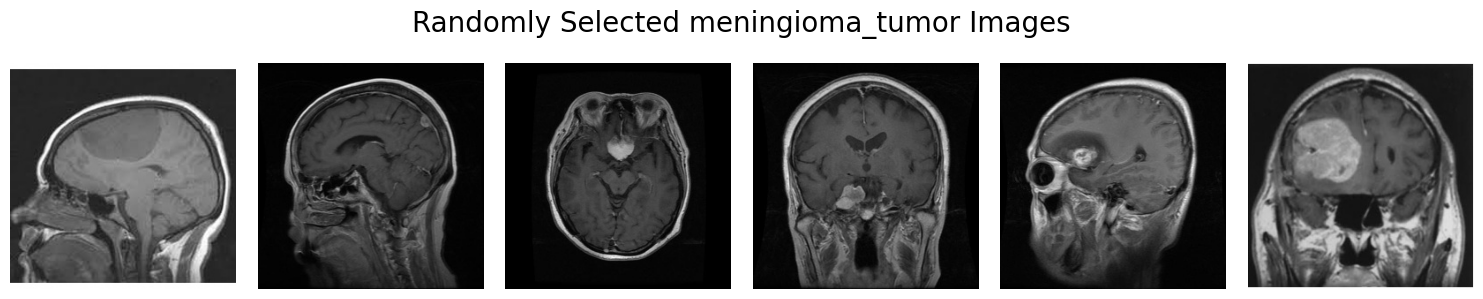

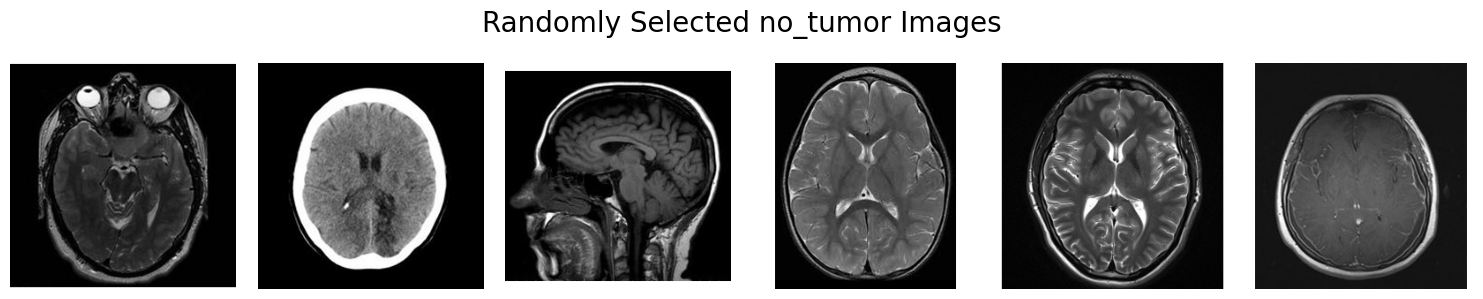

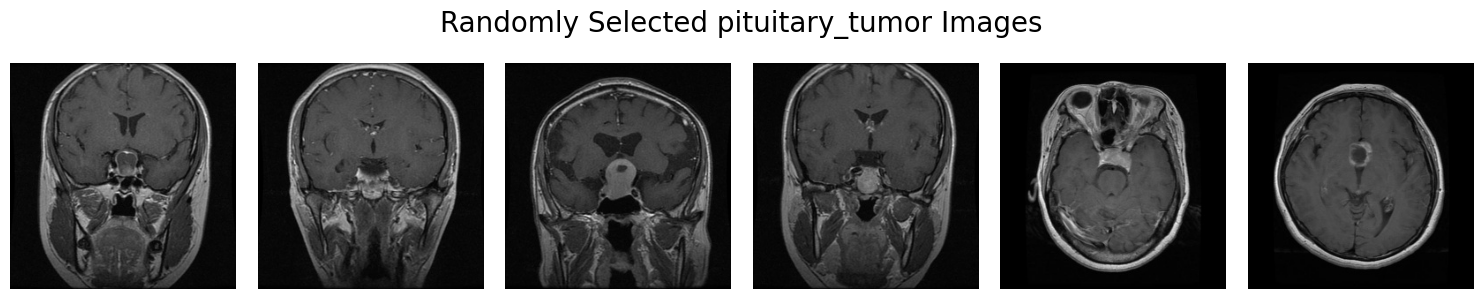

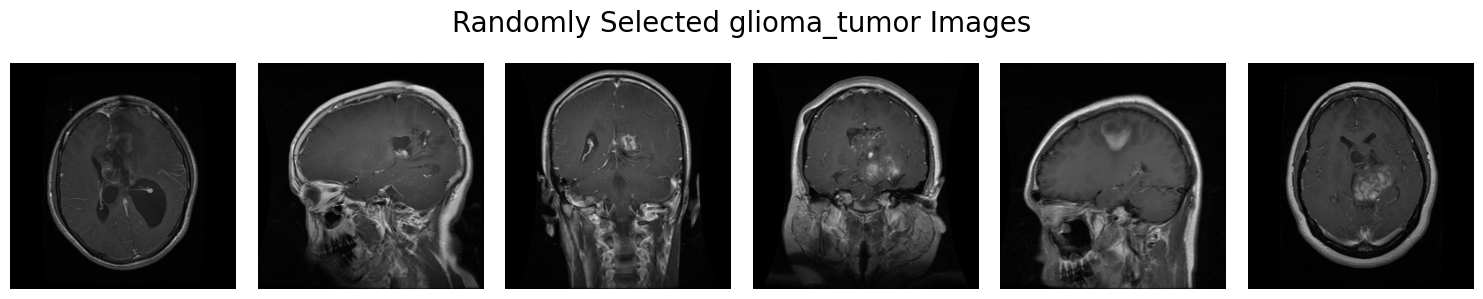

In [16]:
plot_random_images_of_each_class(resize_dir)

Distribution of data:
Total number of images including all classes:  3265


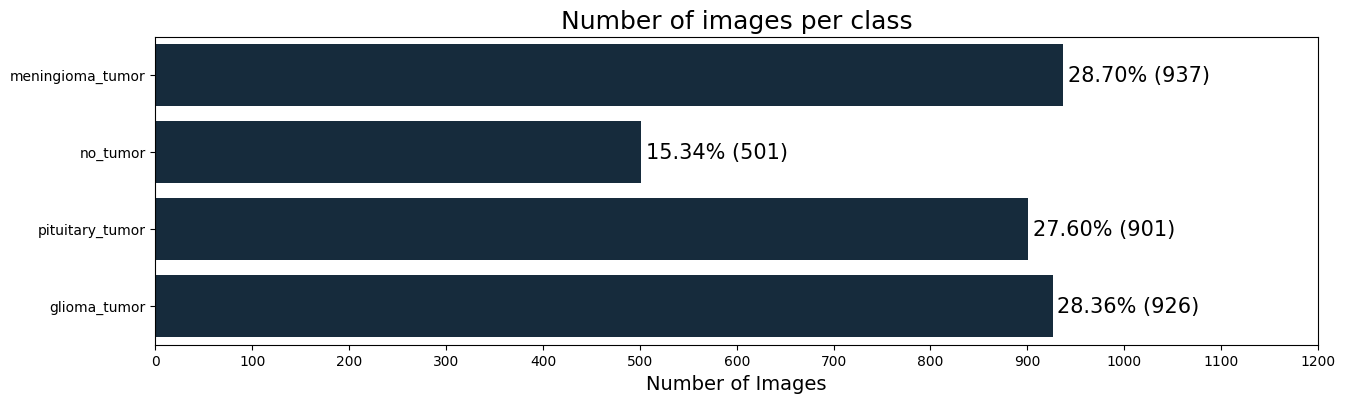

In [17]:
print('Distribution of data:')
counting_images(resize_dir)

### Class Distribution Insights:
The 'no_tumor' class has very less data compare to other three classes which could be critical in ensuring balanced model performance.
So, we Balance the dataset by applying geometric transformations.

# Step 3 | Dataset Preparation

### 3.1 - First of all, I am going to centralize the dataset's information into a DataFrame. This makes it easier to manage and process the data in the subsequent steps:

In [18]:
# fuction to create dataframe of data:
def create_dataframe(base_dir):
    data = []  # Initialize an empty list to store image file paths and their respective labels
    for class_name in classes:  # Loop over each class and append the image file paths with their respective labels to the data list
        folder_path = os.path.join(base_dir, class_name)
        data.extend([(os.path.join(folder_path, filename), class_name) for filename in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, filename))])

    df = pd.DataFrame(data, columns=['filepath', 'label'])   # Convert the collected data into a DataFrame
    return df

In [19]:
# dataframe for resizes training data:
df = create_dataframe(resize_dir)
df.head()

filepath             label
0  resize/meningioma_tumor/resized_m2 (30).jpg  meningioma_tumor
1  resize/meningioma_tumor/resized_m2 (42).jpg  meningioma_tumor
2  resize/meningioma_tumor/resized_m3 (48).jpg  meningioma_tumor
3  resize/meningioma_tumor/resized_m1(196).jpg  meningioma_tumor
4  resize/meningioma_tumor/resized_m (170).jpg  meningioma_tumor

In [20]:
print("Total number of images:", df.shape[0])

Total number of images: 3265


In [21]:
print("Total number of 'no_tumor' images:",len(df[df['label'] == 'no_tumor']))

Total number of 'no_tumor' images: 501


### 3.2 - Balance the training dataset through incresing the data of 'no_tumor' class by applying geometric transformations:

In [22]:
def augment_no_tumor_images(dataframe):
    modified_data = []
    
    for _, row in dataframe.iterrows():
        label = row['label']
        if label == 'no_tumor':
            img_path = row['filepath']
            # Load image and convert it to numpy array
            img = load_img(img_path)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)
            desired_num_images = 900  # Number of images you want after augmentation
            datagen = ImageDataGenerator(  # Augmentation configuration
                rotation_range=20,       # Randomly rotate images in the range (0-20 degrees)
                width_shift_range=0.1,   # Randomly translate images horizontally
                height_shift_range=0.1,  # Randomly translate images vertically
                shear_range=0.1,         # Randomly apply shearing transformations
                zoom_range=0.1,          # Randomly zoom inside pictures
                horizontal_flip=True,    # Randomly flip images horizontally
                fill_mode='nearest'      # Fill mode for newly created pixels
            )
            
            # Generate augmented images
            i = 0
            for batch in datagen.flow(x, batch_size=1):
                i += 1
                # Save the new image with a modified name
                directory, filename = os.path.split(img_path)
                new_img_path = os.path.join(directory, f"modified_{i}_{filename}")
                cv2.imwrite(new_img_path, batch[0].astype('uint8'))  # Save the image using OpenCV
                
                # Append the new image path and its label to the list
                modified_data.append((new_img_path, label))
                
                if i >= (desired_num_images // len(dataframe[dataframe['label'] == 'no_tumor'])):
                    break  # Stop when the desired number of images is reached

    # Create a DataFrame with the modified images and their respective labels
    modified_images_df = pd.DataFrame(modified_data, columns=['filepath', 'label'])
    
    # Return the updated DataFrame with both original and modified images
    return pd.concat([dataframe, modified_images_df], ignore_index=True)

In [23]:
df = augment_no_tumor_images(df)

In [24]:
print("Total number of 'no_tumor' images:",len(df[df['label'] == 'no_tumor']))

Total number of 'no_tumor' images: 1002


In [25]:
print("Total number of images:", df.shape[0])

Total number of images: 3766


Updated Distribution of data:
Total number of images including all classes:  3766


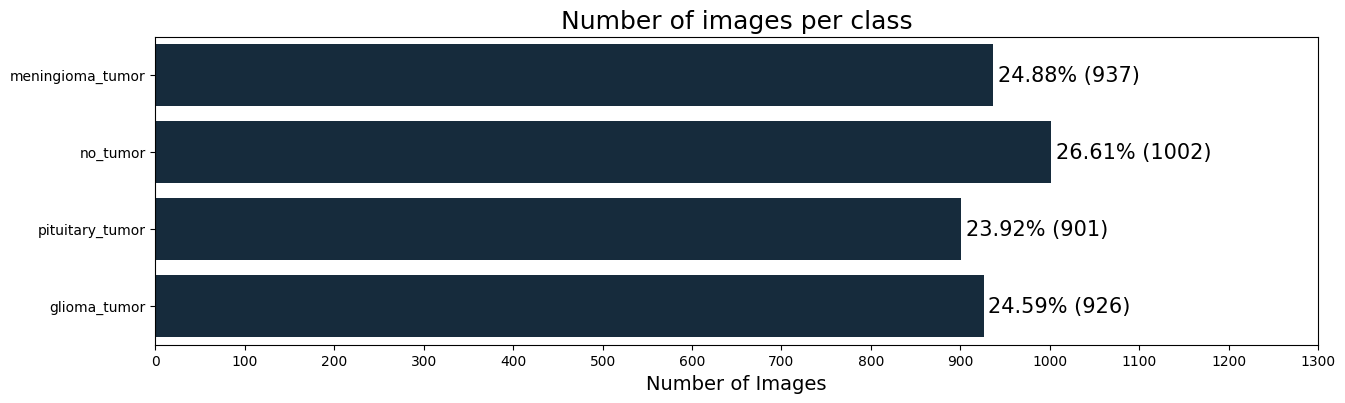

In [26]:
print('Updated Distribution of data:')
counting_images(resize_dir)

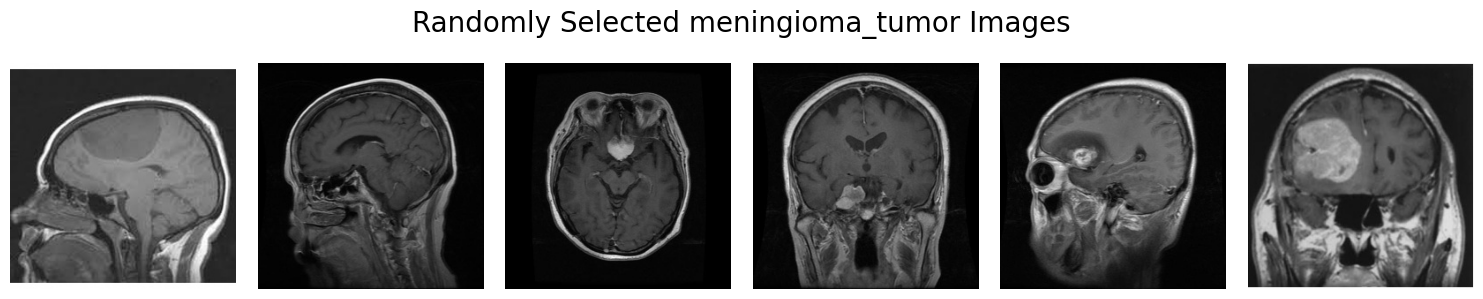

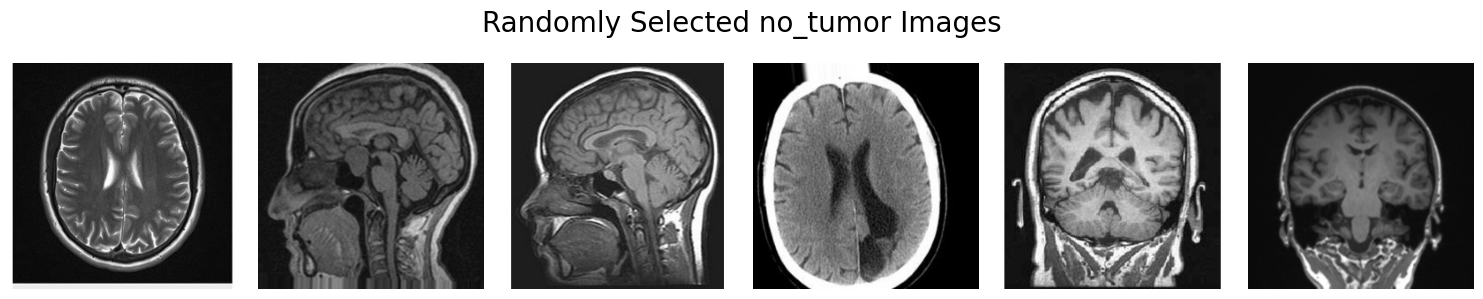

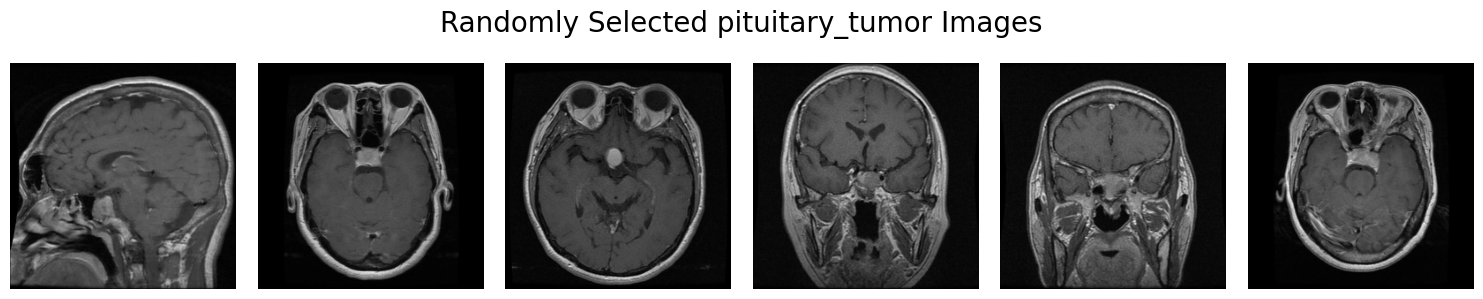

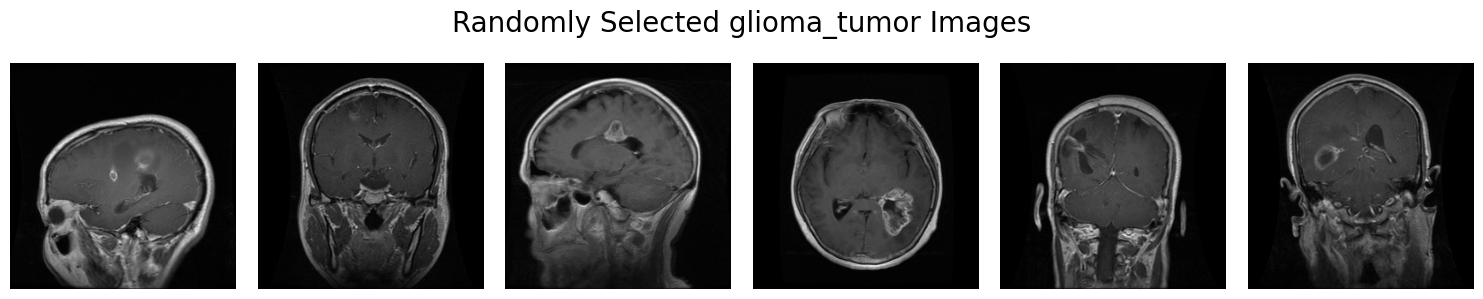

In [27]:
plot_random_images_of_each_class(resize_dir)

### 3.3 - Data Splitting into Training & Validation Sets:
I am going to split our dataset into train and validation sets, ensuring a balanced class distribution with stratification and mixing the images for randomness using shuffling:

In [28]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Display the shape of the training and validation sets
print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)

# Deleting the original DataFrame to free up memory
del df

Training data shape: (3012, 2)
Validation data shape: (754, 2)


In [29]:
train_df.head(10)

filepath             label
2494           resize/glioma_tumor/resized_gg (775).jpg      glioma_tumor
739         resize/meningioma_tumor/resized_m (147).jpg  meningioma_tumor
1562          resize/pituitary_tumor/resized_p (31).jpg   pituitary_tumor
1778         resize/pituitary_tumor/resized_p (217).jpg   pituitary_tumor
2055         resize/pituitary_tumor/resized_p (145).jpg   pituitary_tumor
1301             resize/no_tumor/resized_image(215).jpg          no_tumor
1728         resize/pituitary_tumor/resized_p (450).jpg   pituitary_tumor
1382             resize/no_tumor/resized_image(23)t.jpg          no_tumor
3326  resize/no_tumor/modified_1_resized_image(154).jpg          no_tumor
619         resize/meningioma_tumor/resized_m (131).jpg  meningioma_tumor

In [30]:
val_df.head(10)

filepath             label
3411  resize/no_tumor/modified_1_resized_image(68).jpg          no_tumor
842        resize/meningioma_tumor/resized_m1(158).jpg  meningioma_tumor
2112        resize/pituitary_tumor/resized_p (397).jpg   pituitary_tumor
1396            resize/no_tumor/resized_image(220).jpg          no_tumor
772        resize/meningioma_tumor/resized_m1(113).jpg  meningioma_tumor
1961      resize/pituitary_tumor/resized_image(19).jpg   pituitary_tumor
714         resize/meningioma_tumor/resized_m1(72).jpg  meningioma_tumor
3111          resize/glioma_tumor/resized_gg (588).jpg      glioma_tumor
1943        resize/pituitary_tumor/resized_p (362).jpg   pituitary_tumor
2041         resize/pituitary_tumor/resized_p (78).jpg   pituitary_tumor

In [31]:
def count_images(dataframe):
    """ Function to count the total number of images in a DataFrame """
    return dataframe.shape[0]

In [32]:
# Count and print the number of images in the training and validation sets before the modifications
total_train_images = count_images(train_df)
total_val_images = count_images(val_df)

print(f"Total number of training images: {total_train_images}")
print(f"Total number of validation images: {total_val_images}")

Total number of training images: 3012
Total number of validation images: 754


### 3.4 - Augmentation of Dataset with Artificially Degraded Images
#### Preparing for Low-Quality Image Analysis

Considering our deep learning project on brain tumor MRI may be used in areas with low-quality imaging resources, the goal is to ensure that our model performs accurately with such images. To simulate lower-quality MRIs, I'll employ three techniques:

1. **Adding Noise**: The amount of noise added should be noticeable but not so overwhelming that the key features of the image are obscured. For MRI images, a small to moderate amount of Gaussian noise is often realistic. I will start with a Gaussian noise with a mean of 0 and a small standard deviation (like 0.01 to 0.05 of the pixel value range) and adjust based on the results.
2. **Applying Blur**: For blurring, a Gaussian blur with a small kernel size (e.g., 3x3 or 5x5) can simulate slight focus issues or patient movement. The degree of blur should be enough to reduce sharpness without completely erasing critical details.
3. **Downsampling**: Reducing the image resolution will represent the capabilities of less advanced MRI machinery typically found in under-resourced settings. When downsampling, reducing the image resolution by a factor (e.g., to half or one-third of the original dimensions) and then resizing back to the original size can simulate lower resolution. The key is to degrade the image's clarity while retaining its overall structure

Moving forward, these techniques will be applied to both the training and validation sets separately. This is crucial for understanding how our model performs on degraded images, simulating real-world scenarios where image quality varies. 

Importantly, these modifications are made **after** splitting the data into training and testing sets. This approach prevents **data leakage**, ensuring that the model's performance evaluation is genuine and not influenced by having seen similar images during training. The focus is on ensuring the model truly learns and generalizes, rather than just memorizing.


In [33]:
def add_gaussian_noise(image, mean=0, std=0.05):
    """ Add Gaussian noise to an image """
    gauss = np.random.normal(mean, std, image.shape)
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

def apply_blur(image, kernel_size=5):
    """ Apply Gaussian blur to an image """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def downsample_upsample(image, scale_percent=50):
    """ Downsample and then upsample an image """
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return cv2.resize(resized, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)

In [34]:
def augment_images(dataframe):
    modified_data = []
    
    for _, row in dataframe.iterrows():
        img_path = row['filepath']
        label = row['label']
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Randomly apply one or more degradation methods
        choices = ['noise', 'blur', 'downsample']
        chosen_methods = random.sample(choices, k=random.randint(1, len(choices)))

        if 'noise' in chosen_methods:
            img = add_gaussian_noise(img)
        if 'blur' in chosen_methods:
            img = apply_blur(img)
        if 'downsample' in chosen_methods:
            img = downsample_upsample(img)

        # Save the new image with a modified name
        directory, filename = os.path.split(img_path)
        new_img_path = os.path.join(directory, f"modified_{filename}")
        cv2.imwrite(new_img_path, img)

        # Append the new image path and its label to the list
        modified_data.append((new_img_path, label))

    # Create a DataFrame with the modified images and their respective labels
    modified_images_df = pd.DataFrame(modified_data, columns=['filepath', 'label'])

    # Return the updated DataFrame with both original and modified images
    return pd.concat([dataframe, modified_images_df], ignore_index=True)

In [35]:
# Apply augmentation and update the training and validation datasets
train_df = augment_images(train_df)
val_df = augment_images(val_df)

In [36]:
# Count and print the number of images in the training and validation sets after the modifications
total_train_images = count_images(train_df)
total_val_images = count_images(val_df)

print(f"Total number of training images: {total_train_images}")
print(f"Total number of validation images: {total_val_images}")

Total number of training images: 6024
Total number of validation images: 1508


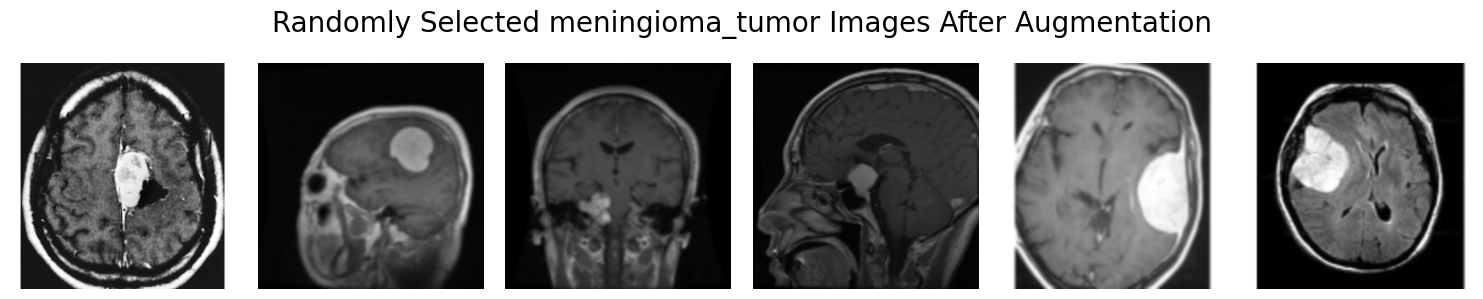

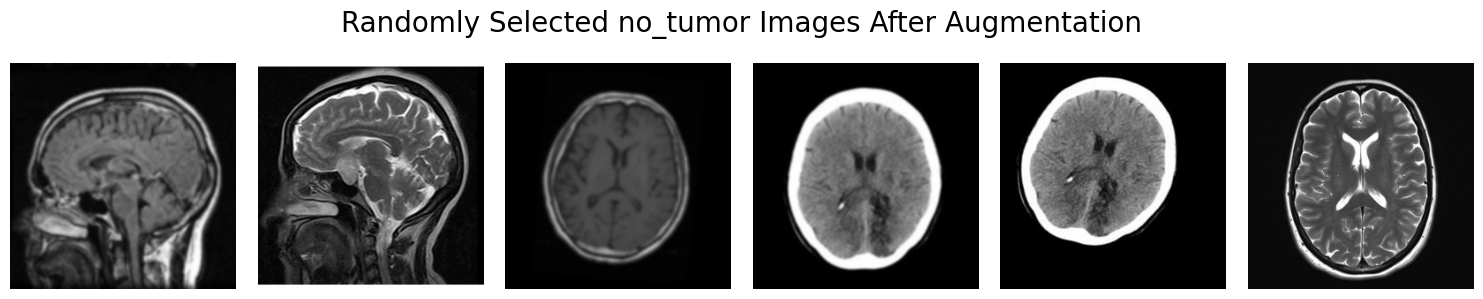

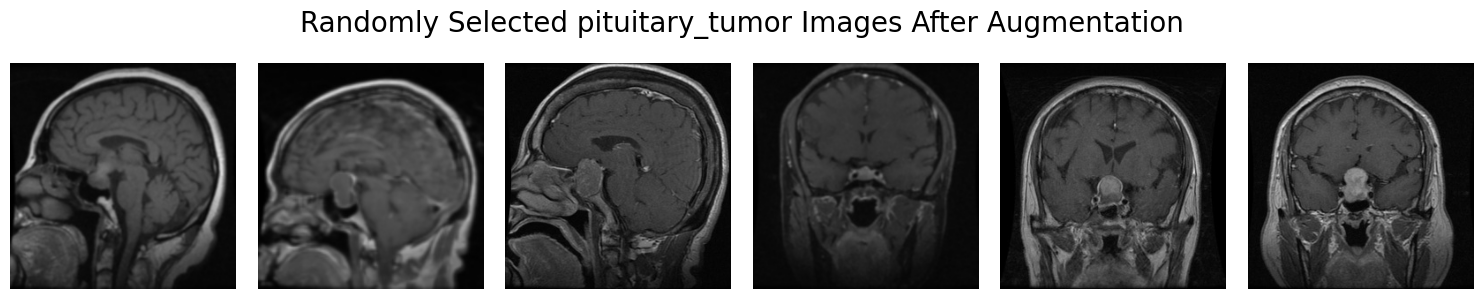

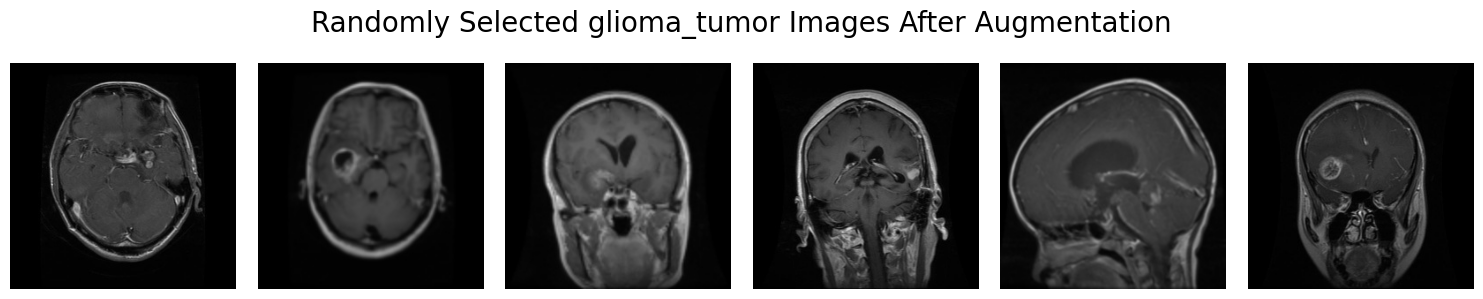

In [37]:
# Loop over each class and plot random images
for class_name in classes:
    folder_path = os.path.join(resize_dir, class_name)
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    random_images = np.random.choice(all_images, 6, replace=False)  # Choose 6 images randomly
    plot_images(random_images, f"Randomly Selected {class_name} Images After Augmentation")

In [38]:
# Function to load images from the file paths
def load_images_and_labels(df, image_dimensions=(256, 256)):
    images = []
    labels = []
    for i, row in df.iterrows():
        img = cv2.imread(row['filepath'])  # Load the image
        img = cv2.resize(img, image_dimensions)  # Resize the image
        images.append(img)
        labels.append(row['label'])
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [39]:
# Load the training and validation data
train_images, train_labels = load_images_and_labels(train_df)
val_images, val_labels = load_images_and_labels(val_df)

In [40]:
# One-hot encode the labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
val_labels = lb.transform(val_labels)

In [41]:
val_df.head()

filepath             label
0  resize/no_tumor/modified_1_resized_image(68).jpg          no_tumor
1       resize/meningioma_tumor/resized_m1(158).jpg  meningioma_tumor
2        resize/pituitary_tumor/resized_p (397).jpg   pituitary_tumor
3            resize/no_tumor/resized_image(220).jpg          no_tumor
4       resize/meningioma_tumor/resized_m1(113).jpg  meningioma_tumor

In [42]:
val_labels[:5]

array([[0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0]])

# Step 4 | Model Architecture Development

In [43]:
# Load the pre-trained ResNet50V2 model without the top layer
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

2024-10-10 08:07:51.105485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21650 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute capability: 8.9


In [44]:
# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout added to prevent overfitting
x = Dense(4, activation='softmax')(x)  # Output layer for multi-class classification

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
# model.summary()

# Step 5 | Full Model Training and Fine-Tuning

In [46]:
num_epochs = 50
# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)

# Train the model on arrays instead of generators
history = model.fit(
    train_images, train_labels,
    batch_size=32,
    epochs=num_epochs,
    validation_data=(val_images, val_labels),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50


I0000 00:00:1728527887.595740   75072 service.cc:145] XLA service 0x71919c003740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728527887.595777   75072 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-10 08:08:08.157474: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-10 08:08:10.059314: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1728527892.959538   75149 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15615', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1728527893.310663   75154 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15617', 40 bytes spill stores, 40 bytes spill loads

I0000 00

  3/189 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.3299 - loss: 1.5350 

I0000 00:00:1728527910.494125   75072 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7714 - loss: 0.5867

I0000 00:00:1728527927.546708   75314 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15615', 4 bytes spill stores, 4 bytes spill loads



189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7720 - loss: 0.5853

I0000 00:00:1728527946.715332   75464 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1524', 224 bytes spill stores, 224 bytes spill loads



189/189 ━━━━━━━━━━━━━━━━━━━━ 79s 221ms/step - accuracy: 0.7726 - loss: 0.5839 - val_accuracy: 0.9383 - val_loss: 0.1621 - learning_rate: 1.0000e-04
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.9828 - loss: 0.0563 - val_accuracy: 0.9569 - val_loss: 0.1348 - learning_rate: 1.0000e-04
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.9903 - loss: 0.0268 - val_accuracy: 0.9324 - val_loss: 0.2769 - learning_rate: 1.0000e-04
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.9850 - loss: 0.0417 - val_accuracy: 0.9702 - val_loss: 0.1108 - learning_rate: 1.0000e-04
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9939 - loss: 0.0195 - val_accuracy: 0.9562 - val_loss: 0.2010 - learning_rate: 1.0000e-04
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.9976 - loss: 0.0111 - val_accuracy: 0.9755 - val_loss: 0.1121 - learning_rate: 1.0000e-04
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accura

# Step 6 | Model Performance Assessment
At this step, I will evaluate the performance of our model in two critical aspects:

1. **Visualizing the Learning Curves**: Analyze the training and validation loss and accuracy over epochs to assess model convergence and detect overfitting or underfitting.
   
2. **Performance Metrics Assessment**: Evaluate key performance metrics such as accuracy, precision, recall, F1-score, and confusion matrix to comprehensively understand how well the model generalizes and performs on the test data.


### 6.1 - Visualizing the Learning Curves

In [47]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """
    df = pd.DataFrame(history.history)          # Convert the history.history dict to a pandas DataFrame
    df = df.iloc[start_epoch-1:]                # Plot the curves from the specified epoch onwards
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid') # Set the style of seaborn for better visualization
    plt.figure(figsize=(15,6))                  # Plotting the learning curves

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='#102C42', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='#102C42', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

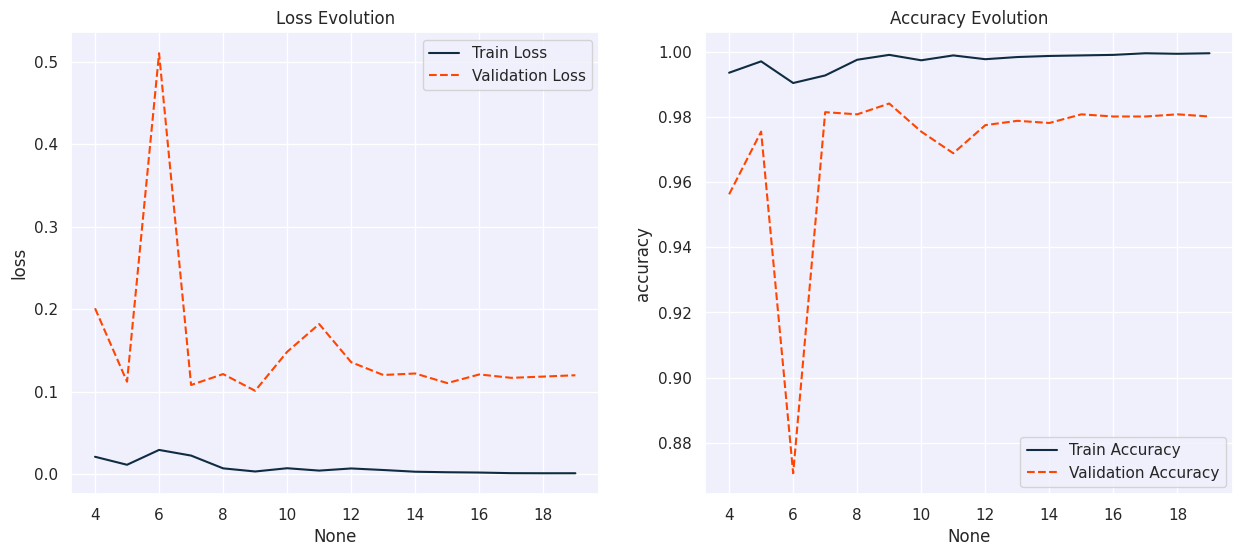

In [48]:
plot_learning_curves(history)

### Model Learning Curve Analysis:
    From the learning curves, it's clear that the training loss is decreasing and leveling out, which is a good sign that the model is learning effectively from the training data. The training accuracy is high and stable, indicating strong performance on the training set. The validation accuracy is slightly lower than the training accuracy but remains relatively high, which means the model is performing well on unseen data too. Overall, the model seems to be performing well.

### 6.2 - Performance Metrics Assessment:
Now, we're set to assess the model's performance on the validation set, focusing on key metrics. I'll explore accuracy, precision, recall, and F1-score for a well-rounded understanding of how effectively the model classifies brain MRI images. Additionally, a confusion matrix will provide valuable insights into the model's prediction accuracy for each class, helping us identify any specific areas for improvement:

In [49]:
def evaluate_model_performance(model, val_images, val_labels, class_labels):
    """
    Evaluate the model's performance on the validation set, print the classification report, and plot the confusion matrix.

    Parameters:
    - model: The trained model.
    - val_images: Validation images (input data for the model).
    - val_labels: True labels (one-hot encoded) for the validation set.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """
    true_labels = np.argmax(val_labels, axis=1)    # Get true labels by converting one-hot encoded labels to class indices
    predictions = model.predict(val_images)        # Predict labels using the trained model
    predicted_labels = np.argmax(predictions, axis=1) # Get the predicted class indices from the predictions
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)  # Generate classification report
    print(report)
    cm = confusion_matrix(true_labels, predicted_labels)     # Create a confusion matrix

    # Define a custom colormap for the confusion matrix
    colors = ["white", "#102C42"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)
    # Plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return report


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step
                  precision    recall  f1-score   support

meningioma_tumor       0.98      0.96      0.97       370
        no_tumor       0.97      0.98      0.98       376
 pituitary_tumor       0.99      1.00      0.99       402
    glioma_tumor       0.99      0.99      0.99       360

        accuracy                           0.98      1508
       macro avg       0.98      0.98      0.98      1508
    weighted avg       0.98      0.98      0.98      1508



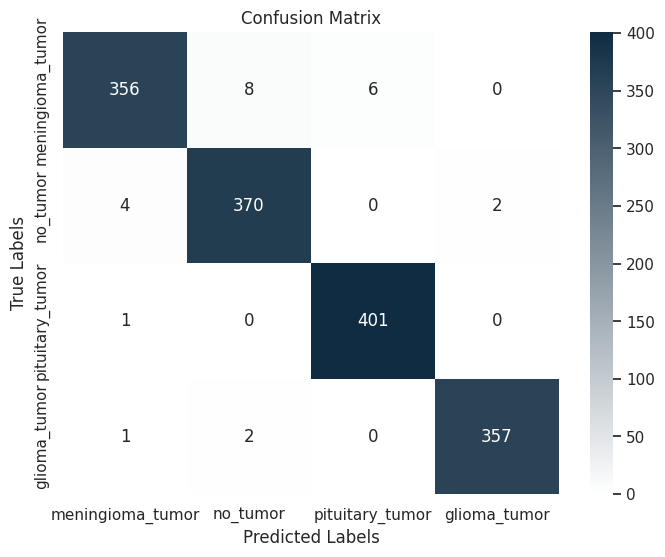

'                  precision    recall  f1-score   support\n\nmeningioma_tumor       0.98      0.96      0.97       370\n        no_tumor       0.97      0.98      0.98       376\n pituitary_tumor       0.99      1.00      0.99       402\n    glioma_tumor       0.99      0.99      0.99       360\n\n        accuracy                           0.98      1508\n       macro avg       0.98      0.98      0.98      1508\n    weighted avg       0.98      0.98      0.98      1508\n'

In [50]:
evaluate_model_performance(model,val_images, val_labels , classes)

In [51]:
len(val_df[val_df['label'] == 'pituitary_tumor'])

360

### Model Validation Performance Review:
The model's validation performance is impressive. The confusion matrix shows that it can distinguish between the different tumor types with high accuracy, rarely confusing one type for another. The classification report further illustrates this with high precision and recall across all classes, indicating both a low number of false positives and false negatives. Specifically, the model is exceptionally precise in identifying 'normal' cases without tumors. Overall, the high F1-scores across all categories reflect a well-balanced model that performs consistently across the board.

# Step 7 | Saving the Model for Deployment

In this final step, I am securing our hard work by saving the fully trained ResNet50V2 model. This includes both the model's weights and its architecture, ensuring we can deploy it effectively in a Web Application. I'll use a function to zip and download it, making it easily accessible for future use and deployment:

In [52]:
# Save the entire ResNet50V2 model
classifier = model.save('ResNet50V2_model_for_tumor.keras')